# PLDE Project
## Modeling Behavioural Changes in Epidemics with Age Compartments
The notebook aims to implement a SIR model on a homogeneus mixing population. The population is divided in 3 age cathegories: (Y) Youth, (A) Adult and (E) Elderly. Their behaviour and transition rates in the various compartments of the disease is relative to their age. Moreover, their attitude towards the Epidemics (modeled with fear) changes depending on the epidemic situation and the age.

### 1. Libraries

In [1]:
import numpy as np
import pandas as pd
import kagglehub
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, CenteredNorm


### 2. Model Setup - Contact data
The population is divided in 3 age compartments (Y,A,E), 3 infection compartments (S,I,R) and 2 fear compartments (F,NF). Their behaviour is subject to being in each one of the 18 categories that emerge when combining the 3 independent information.
First off, let's model the interactions. As a reference we'll use the famous publication by J. Mossong et al: **Social Contacts and Mixing Patterns Relevant to the Spread of Infectious Diseases**. According to the publication, contacts are far stronger between individuals with similar age, while are rarer between different ages, with exception of parental bonds (parents-children, adults-grandparents). We will use the same dataset of the paper (**POLYMOD**) to retrieve a matrix for modeling contacts. We'll consider individuals from 0 to 18 years old to be Y, from 19 to 65 to be A, 66 and above to be E.


In [2]:
data_path = kagglehub.dataset_download("thedevastator/polymod-social-contacts-data")
files = os.listdir(data_path)
print(f"Available files: {files}")

Available files: ['2008_Mossong_POLYMOD_sday.csv', '2008_Mossong_POLYMOD_contact_common.csv', '2008_Mossong_POLYMOD_hh_common.csv', '2008_Mossong_POLYMOD_participant_common.csv', '2008_Mossong_POLYMOD_hh_extra.csv', '2008_Mossong_POLYMOD_participant_extra.csv']


In [3]:
participants = pd.read_csv(os.path.join(data_path, "2008_Mossong_POLYMOD_participant_common.csv"))
contacts = pd.read_csv(os.path.join(data_path, '2008_Mossong_POLYMOD_contact_common.csv'))
nationalities = pd.read_csv(os.path.join(data_path, '2008_Mossong_POLYMOD_participant_extra.csv'))

/tmp/ipykernel_16052/2323981888.py:2: DtypeWarning: Columns (6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  contacts = pd.read_csv(os.path.join(data_path, '2008_Mossong_POLYMOD_contact_common.csv'))


In [4]:
participants

,part_id,hh_id,part_age,part_gender
0,1,Mo08HH1,8.0,F
1,2,Mo08HH2,6.0,M
2,3,Mo08HH3,0.0,F
3,4,Mo08HH4,1.0,M
4,5,Mo08HH5,2.0,M
...,...,...,...,...
7285,8000,Mo08HH8000,26.0,M
7286,8001,Mo08HH8001,14.0,F
7287,50036,Mo08HH50036,45.0,F
7288,50037,Mo08HH50037,54.0,F


In [5]:
contacts


,part_id,cont_id,cnt_age_exact,cnt_age_est_min,cnt_age_est_max,cnt_gender,cnt_home,cnt_work,cnt_school,cnt_transport,cnt_leisure,cnt_otherplace,frequency_multi,phys_contact,duration_multi
0,1,101,42.0,42.0,NaN,F,True,False,False,False,False,False,1.0,1.0,4.0
1,1,102,9.0,9.0,NaN,F,False,False,True,False,False,False,1.0,1.0,5.0
2,1,103,42.0,40.0,45.0,F,False,False,False,False,True,False,3.0,1.0,4.0
3,1,104,8.0,8.0,NaN,F,False,False,True,False,False,False,1.0,1.0,5.0
4,1,105,29.0,28.0,30.0,F,False,False,True,False,False,False,2.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97899,8001,800124,11.0,11.0,NaN,F,True,False,False,False,False,False,1.0,1.0,5.0
97900,8001,800125,3.0,3.0,NaN,M,True,False,False,False,False,False,1.0,1.0,5.0
97901,8001,800126,43.0,43.0,NaN,F,True,False,False,False,False,False,1.0,1.0,5.0
97902,8001,800127,33.0,33.0,NaN,F,False,False,False,False,False,True,4.0,1.0,3.0


In [6]:
nationalities

,part_id,type,part_occupation,part_occupation_detail,part_education,part_education_length,participant_school_year,participant_nationality,child_care,child_care_detail,child_relationship,child_nationality,problems,diary_how,diary_missed_unsp,diary_missed_skin,diary_missed_noskin
0,1,3,5.0,7.0,3.0,13.0,NaN,IT,Y,NaN,2.0,IT,N,2.0,2.0,NaN,NaN
1,2,3,5.0,7.0,3.0,11.0,NaN,IT,Y,NaN,1.0,IT,N,3.0,1.0,NaN,NaN
2,3,3,6.0,7.0,3.0,13.0,NaN,IT,N,NaN,1.0,IT,N,2.0,1.0,NaN,NaN
3,4,3,6.0,NaN,3.0,13.0,NaN,IT,N,NaN,1.0,IT,N,2.0,1.0,NaN,NaN
4,5,3,6.0,7.0,6.0,18.0,NaN,IT,N,NaN,1.0,IT,N,3.0,2.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,8000,1,1.0,7.0,7.0,15.0,NaN,BE,NaN,NaN,NaN,NaN,N,2.0,1.0,NaN,NaN
7286,8001,1,5.0,NaN,2.0,11.0,NaN,BE,NaN,NaN,NaN,NaN,N,1.0,3.0,NaN,NaN
7287,50036,1,1.0,7.0,3.0,9.0,NaN,BE,NaN,NaN,NaN,NaN,N,2.0,1.0,NaN,NaN
7288,50037,1,3.0,NaN,7.0,15.0,NaN,BE,NaN,NaN,NaN,NaN,N,2.0,1.0,NaN,NaN


Now we merge the dataframes to get the final datatable. We merge the dataframes on **part_id** which is the primary key of all tables, then we select only italian nationality data.

In [7]:
# merge the dataframes to get desired data
data = pd.merge(participants,contacts, how = 'inner')[['part_id','part_age','cnt_age_exact','frequency_multi','duration_multi']]
data = pd.merge(data, nationalities, how = 'inner')[['part_id','part_age','cnt_age_exact','frequency_multi','duration_multi','participant_nationality']]
print(f"Data has {np.shape(data)[0]} entries")
# drop NaN
data = data.dropna()
print(f"Data has {np.shape(data)[0]} entries after dropping NA")

# select only italians
data = data[data['participant_nationality'] == 'IT']
print(f"Data has {np.shape(data)[0]} entries after selecting only IT")

data


Data has 97904 entries
Data has 71513 entries after dropping NA
Data has 16118 entries after selecting only IT


,part_id,part_age,cnt_age_exact,frequency_multi,duration_multi,participant_nationality
0,1,8.0,42.0,1.0,4.0,IT
1,1,8.0,9.0,1.0,5.0,IT
2,1,8.0,42.0,3.0,4.0,IT
3,1,8.0,8.0,1.0,5.0,IT
4,1,8.0,29.0,2.0,3.0,IT
...,...,...,...,...,...,...
16779,845,11.0,11.0,1.0,5.0,IT
16780,845,11.0,11.0,1.0,5.0,IT
16781,845,11.0,11.0,1.0,5.0,IT
16782,845,11.0,11.0,1.0,5.0,IT


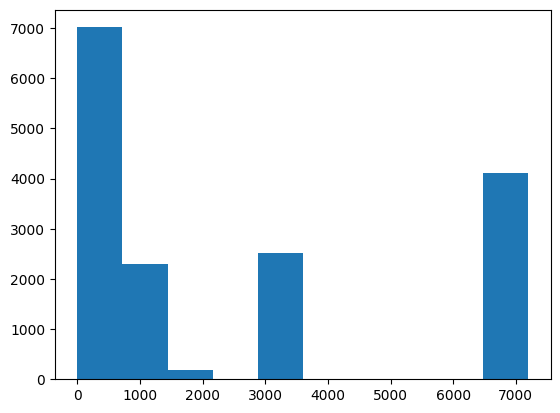

,part_id,part_age,cnt_age_exact,frequency_multi,duration_multi,participant_nationality,part_cat,cont_cat,time
0,1,8.0,42.0,30.0,120.0,IT,Y,A,3600.0
1,1,8.0,9.0,30.0,240.0,IT,Y,Y,7200.0
2,1,8.0,42.0,1.5,120.0,IT,Y,A,180.0
3,1,8.0,8.0,30.0,240.0,IT,Y,Y,7200.0
4,1,8.0,29.0,8.0,37.5,IT,Y,A,300.0
...,...,...,...,...,...,...,...,...,...
16779,845,11.0,11.0,30.0,240.0,IT,Y,Y,7200.0
16780,845,11.0,11.0,30.0,240.0,IT,Y,Y,7200.0
16781,845,11.0,11.0,30.0,240.0,IT,Y,Y,7200.0
16782,845,11.0,11.0,30.0,240.0,IT,Y,Y,7200.0


In [8]:
# define categories
data['part_cat'] = ['Y' if x <= 16.5 else(
                    'A' if x<= 65.5
                    else 'E') for x in data['part_age']]
data['cont_cat'] = ['Y' if x <= 18.5 else(
                    'A' if x<= 65.5
                    else 'E') for x in data['cnt_age_exact']]

# we shall now consider the columns frequency and duration
# duration categories: (1,2,3,4,5) are (less 5 min, 5 to 15 min, 15 min to 1h, 1-4 h, more than 4h)
# frequency categories: (1,2,3,4,5) are (daily, 1/2 times a week, 1/2 times a month, less than once a month, first time)
# we want the total time of the contacts. To achieve this we fix a time amount to compute, which is the number of minutes of contact in a full month
# we will substitue the rescaling factors in duration and frequency
data['frequency_multi'] = [30 if x == 1.0 else(
                            8 if x == 2.0 else(
                            1.5 if x == 3.0 else(
                            0.5 if x == 4.0 else(
                            1    
                            ))))for x in data['frequency_multi']]
data['duration_multi'] = [2.5 if x == 1.0 else(
                            10 if x == 2.0 else(
                            37.5 if x == 3.0 else(
                            120 if x == 4.0 else(
                            240    
                            ))))for x in data['duration_multi']]

# now compute the time (in minutes) in a month for the given contact
data['time'] = data['frequency_multi'] * data['duration_multi']

plt.hist(data['time'])
plt.show()
data

In [9]:
# Count contact time by exact age
contacts = data.groupby(['part_age','cnt_age_exact'], as_index=False)['time'].sum()
contacts_matrix = contacts.pivot(index='part_age', columns='cnt_age_exact', values='time')

# count counts
contacts_c = data.groupby(['part_age','cnt_age_exact'], as_index=False)['time'].sum()
contacts_c_matrix = contacts_c.pivot(index='part_age', columns='cnt_age_exact', values='time')

# Count of participants by EXACT AGE (not categories!)
participant_counts = data.groupby('part_age')['part_id'].nunique()

print("Contacts \n", contacts_matrix, "\n")
print("Participant counts \n", participant_counts, "\n")

# Normalize
norm_contacts_matrix = contacts_matrix.div(participant_counts, axis=0)
print("Normalized contact matrix:\n", norm_contacts_matrix, "\n")

Contacts 
 cnt_age_exact   0.0      1.0       2.0        3.0       4.0       5.0   \
part_age                                                                 
0.0            960.0      NaN       NaN     332.50     300.0       NaN   
1.0              NaN  58080.0       NaN    9225.00    4725.0       NaN   
2.0              NaN  14400.0   29925.0   21618.75   11925.0    7380.0   
3.0              NaN  38325.0  390295.0  522971.25  119210.0   87587.5   
4.0              NaN      NaN    7870.0   43090.00  174280.0  147957.5   
...              ...      ...       ...        ...       ...       ...   
77.0             NaN      NaN       NaN        NaN       NaN       NaN   
79.0             NaN      NaN       NaN        NaN       NaN       NaN   
80.0             NaN      NaN       NaN        NaN       NaN       NaN   
81.0             NaN      NaN       NaN        NaN       NaN       NaN   
82.0             NaN      NaN      10.0        NaN       NaN       NaN   

cnt_age_exact     6.0     

Here we have a Matrix representing the contact time between the three categories. We can take the sum of the symmetric terms.

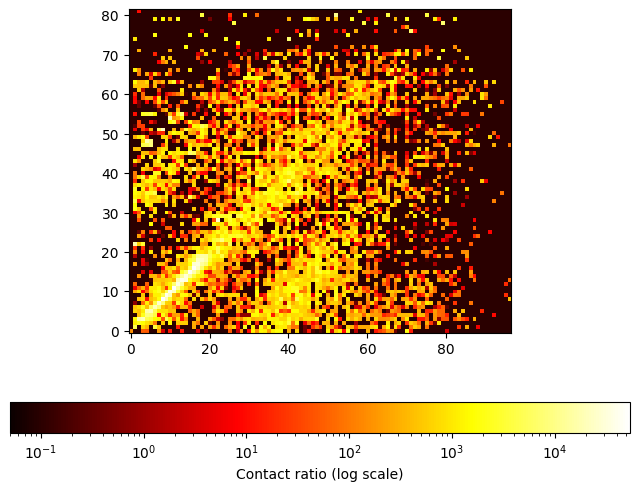

In [10]:
# put zeros in places of NaN
norm_contacts_matrix[norm_contacts_matrix.isna()] = 0.1 # the log handles 0 poorly

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(norm_contacts_matrix, cmap='hot', norm=LogNorm())
plt.colorbar(im, ax=ax, label="Contact ratio (log scale)", orientation="horizontal")
ax.invert_yaxis()
plt.show()

We now want the matrix only for the threee selected categories

In [11]:
# Count contact time by exact age
contacts = data.groupby(['part_cat','cont_cat'], as_index=False)['time'].sum()
contacts_matrix = contacts.pivot(index='part_cat', columns='cont_cat', values='time')

# Count of participants by categories!
participant_counts = data.groupby('part_cat')['part_id'].nunique()

print("Contacts \n", contacts_matrix, "\n")
print("Participant counts \n", participant_counts, "\n")


# Normalize
norm_contacts_matrix = contacts_matrix.div(participant_counts, axis=0)
print("Normalized contact matrix:\n", norm_contacts_matrix, "\n")

Contacts 
 cont_cat            A          E            Y
part_cat                                     
A         11428490.00  903536.25   6512196.25
E           227856.25  147693.75     58971.25
Y          5474695.00  578060.00  16935011.25 

Participant counts 
 part_cat
A    513
E     39
Y    282
Name: part_id, dtype: int64 

Normalized contact matrix:
 cont_cat             A            E             Y
part_cat                                         
A         22277.758285  1761.279240  12694.339669
E          5842.467949  3787.019231   1512.083333
Y         19413.812057  2049.858156  60053.231383 



In [26]:
contacts_c

,part_cat,cont_cat,part_id,part_age,cnt_age_exact,frequency_multi,duration_multi,participant_nationality,time
0,A,A,6905,6905,6905,6905,6905,6905,6905
1,A,E,640,640,640,640,640,640,640
2,A,Y,2080,2080,2080,2080,2080,2080,2080
3,E,A,263,263,263,263,263,263,263
4,E,E,91,91,91,91,91,91,91
5,E,Y,33,33,33,33,33,33,33
6,Y,A,2036,2036,2036,2036,2036,2036,2036
7,Y,E,280,280,280,280,280,280,280
8,Y,Y,3790,3790,3790,3790,3790,3790,3790


In [28]:
contacts_c = data.groupby(['part_cat','cont_cat'], as_index=False).count()
contacts_c_matrix = contacts_c.pivot(index='part_cat', columns='cont_cat', values='part_id')

print("Contacts counts \n",contacts_c_matrix)

Contacts counts 
 cont_cat     A    E     Y
part_cat                 
A         6905  640  2080
E          263   91    33
Y         2036  280  3790


In [13]:
# symmetrize the matrix and normalize rows to 1
norm_contacts_matrix = (norm_contacts_matrix + norm_contacts_matrix.T)/2
norm_contacts_matrix = norm_contacts_matrix.div(norm_contacts_matrix.sum(axis = 1), axis = 0)

In [14]:
norm_contacts_matrix

cont_cat,A,E,Y
part_cat,,,
A,0.528740,0.090234,0.381027
E,0.405755,0.404170,0.190074
Y,0.206117,0.022866,0.771018


### 3. Model Setup - Compartments
We will have in total 12 compartments: 3 feared and 9 not feared. Each age class will contain 1 of the feared compartments ($S_f$) and the 3 standard SIR compartments. Interaction between age classes will be mediated via the contact matrix.

First off, we want to model the population of Italy. Whatever the choice for the total number of individuals in the population $N$, we want the fraction of each age class to be proportional to the real data. We got the data from https://demo.istat.it/app/?i=POS&l=en


In [15]:
# retrieve the data
pop_data = pd.read_csv("Resident population.csv")
total_IT_pop = pop_data['Total'].iloc[-1]
print(f"Total Italy population: {total_IT_pop} individuals")

pop_data

Total Italy population: 58943464 individuals


,Age,Total males,Total females,Total
0,0,190323,180121,370444
1,1,197611,186695,384306
2,2,206419,194040,400459
3,3,210340,200030,410370
4,4,214926,202396,417322
...,...,...,...,...
97,97,6907,23882,30789
98,98,4424,16786,21210
99,99,2584,11410,13994
100,100 and over,3976,18676,22652


In [16]:
# handle the last 2 lines 
pop_data.loc[100,'Age'] = 100
pop_data = pop_data.loc[:100,:]
pop_data

,Age,Total males,Total females,Total
0,0,190323,180121,370444
1,1,197611,186695,384306
2,2,206419,194040,400459
3,3,210340,200030,410370
4,4,214926,202396,417322
...,...,...,...,...
96,96,10315,33002,43317
97,97,6907,23882,30789
98,98,4424,16786,21210
99,99,2584,11410,13994


In [17]:
pop_data_table = np.array(pop_data, dtype = float)
Y_pop = np.sum(pop_data_table[0:19,3])
A_pop = np.sum(pop_data_table[19:66,3])
E_pop = np.sum(pop_data_table[66:,3])
print(f"Total Y population: {Y_pop}, corresponding to {Y_pop/total_IT_pop*100}%")
print(f"Total A population: {A_pop}, corresponding to {A_pop/total_IT_pop*100}%")
print(f"Total E population: {E_pop}, corresponding to {E_pop/total_IT_pop*100}%")

Total Y population: 9356661.0, corresponding to 15.873958476549666%
Total A population: 35807880.0, corresponding to 60.74953450309605%
Total E population: 13778923.0, corresponding to 23.376507020354286%


Now that we have real population data we can setup the simulation

### 4. Dynamics and simulation
Each of the 3 age classes will follow a SIR model with fear, which will be only present in $S_f$ class. The dynamic will consider an homogeneus mixing, but will account for contact interaction between different age classes.

For now, let's consider a monoclass SIR model with fear:
we have several available reactions:


$S + I \rightarrow I + I $ with rate $\beta$ <br>
$I \rightarrow R$ with rate $\mu$<br>
This is the standard SIR which has the following dynamics:<br>
$dS(t)=-\beta S(t)\frac{I(t)}{N}$<br>
$dI(t)=-\mu I(t) +\beta S(t)\frac{I(t)}{N}$<br>
$dR(t)=\mu I(t) $<br> 
With an easy way to compute the **basic reproductive number** if we assume homogeneous mixing, that is: <br>
$R_0 =\frac{\beta}{\mu}$<br>
<br>
To introduce **fear** we must consider how the information about the epidemic can reach individuals. Moreover, **fear** itself changes the behaviour of the individual, making it more careful. This can be encaptured by the following reaction: <br>
$S^F + I \rightarrow 2I$ with rate $r_\beta \beta$ where $0 \leqslant r_\beta < 1$<br>
The introduction of $r_\beta$ parameter then modulates the force of infection, leading to a reduction of the transmission rate. Another considerable effect is the "scare" of meeting an infected individual that leads to a change in behaviour. This can be represented by the following reaction: <br>
$S+I\rightarrow S^F+I$ with rate $\beta_F$<br>
The reaction suggests that basically **fear** is **being spread in the same way as the epidemic does**, but with a different rate. On the same reaction we can model the spread of information across public media. The transition rate is:<br>
$\lambda = \beta_F(1-e^{-\delta I(t)})$ (transition is $S \rightarrow S^F$)<br>
Which has an effect even for small $I$ population over all the population. Other than that, local beliefs can be transmitted also between S people:<br>
$S+S^F\rightarrow2S^F$ with rate $\alpha\beta$ where $\alpha$ modulates the transmission rate by contacting infected individuals and contacting individuals with fear of disease. Then we can model the "inverse" local interaction as: <br> 
$S^F+R\rightarrow S+R$ with rate $\mu_F$, representing the chance of fear vanishing by meeting a recovered individual. Another is also possible: <br>
$S^F+S \rightarrow 2S$, representing the spread of a misinformation rumor. 

We finally get the laws for the dynamics of a SIR system with fear: <br>
$dS(t) = - \beta \frac{I(t)}{N}S(t) - \beta_F \frac{I(t)}{N}S(t) - \alpha \beta_F \frac{S(t)}{N}S^F(t) + \alpha \beta_F \frac{R(t)}{N}S^F(t) + \alpha \beta_F \frac{S(t)}{N}S^F(t) + \mu_F S^F(t)$<br>
$dS^F(t)= -r_\beta \beta \frac{I(t)}{N}S^F(t) + \beta_F \frac{I(t)}{N}S(t) + \alpha \beta_F \frac{S(t)}{N}S^F(t) - \alpha \beta_F \frac{R(t)}{N}S^F(t) - \alpha \beta_F \frac{S(t)}{N}S^F(t) - \mu_F S^F(t)$<br>
$dI(t)=-\mu I(t)+\beta \frac{I(t)}{N}S(t)+ r_\beta \beta \frac{I(t)}{N}S^F(t)$<br>
$dR(t)=\mu I(t)$

We will apply such ODE to all 12 compartments, mediating the interaction between compartments with the contact matrix. For example, in standard SIR settings, considering the contact matrix:<br>
$C_{ij}=\begin{bmatrix}C_{yy} & C_{ya} & C_{ye} \\ C_{ay} & C_{aa} & C_{ae} \\ C_{ey} & C_{ea} & C_{ee}\end{bmatrix}$<br>
We will update the $i-th$ compartment of the $S$ class with:<br>
$dS_i(t)=-S_i(t)\sum_{j=1}^{3}(\beta C_{ij} \frac{I_j(t)}{N_j} )$

Let's start things off by defining the **initial conditions**:<br>
### 4.1 Initial conditions

In [18]:
# total amount of population
N = 1e4

# distribution in age classes
Y = int(N*Y_pop/total_IT_pop)
A = int(N*A_pop/total_IT_pop)
E = int(N*E_pop/total_IT_pop)
pop = np.array([A,E,Y])
print(f"Population distribution: \nY = {Y}\nA = {A}\nE = {E}")

Population distribution: 
Y = 1587
A = 6074
E = 2337


In [19]:
# we shall distribute a number of initial infected individuals across classes
# here we assume a ~ uniform distribution across the classes
I_0 = 50                    # 105k infected of Covid-19 in Italy at end of March 2020
I_A0 = int(I_0/2)           # initial A infected
I_Y0 = int((I_0 - I_A0)/2)  # initial Y infected
I_E0 = I_0 - I_A0 - I_Y0    # initial E infected
print(I_Y0,I_A0,I_E0)

12 25 13


### 4.2 Parameters
We have a set of parameters for each SIR, and they can change based on the age class

In [20]:
# class order: A E Y
beta = np.array([0.3, 0.2, 0.3])       # transmission rates
mu = np.array([0.1, 0.05, 0.12])        # recovery rates       

r_beta = np.array([0.3, 0.1, 0.3])    # reduction of transmissibility due to fear
beta_F = np.array([0.8, 0.7, 1.2])     # fear spread
alpha = np.array([0.6, 0.6, 0.6])      # weighting of fear in spreading between S Sf
mu_F = np.array([0.3, 0.3, 0.3])      # fear reduction due to S - R interaction

# Simulation
total_timesteps = 150000  # Longer simulation to see both peaks
dt = 0.01
# contact matrix
cm = np.array(norm_contacts_matrix)

### 4.3 Arrays to save data

In [21]:
# class order: A E Y
S = np.zeros((total_timesteps+1,3))
I = np.zeros((total_timesteps+1,3))
R = np.zeros((total_timesteps+1,3))
Sf = np.zeros((total_timesteps+1,3))
l = np.zeros((total_timesteps+1,3))            # to store FOI
I[0,:] = [I_A0,I_E0,I_Y0]                # initialization of timestep 0 (initial condition
S[0,:] = pop - I[0,:]
R[0,:] = [0,0,0]                         # may change this to include "vaccination"
Sf[0,:] = [0,0,0]                        # may change this

### 4.4 Dynamics logic

In [22]:
# t for
for t in range(1,total_timesteps+1):
    for i in range(np.shape(S)[1]):      # i is the index of the selected compartment
        # dS computations
        # 1st element, S individuals lost to infection
        # 2nd element, S individuals lost to fear (interaction with I)
        # 3rd element, S individuals lost to fear (interaction with S Sf)
        # 4th element, S individuals regained from fear (interaction Sf R)
        # 5th element, S individuals regained from fear (interaction S Sf)
        
        dS = (-beta[i] * S[t-1, i] * np.sum(cm[i, :] * I[t-1, :] / pop) 
      - beta_F[i] * S[t-1, i] * np.sum(cm[i, :] * I[t-1, :] / pop) 
      - alpha[i] * beta_F[i] * S[t-1, i] * np.sum(cm[i, :] * Sf[t-1, :] / pop) 
      + mu_F[i] * Sf[t-1, i] * np.sum(cm[i, :] * R[t-1, :] / pop) 
      + mu_F[i] *Sf[t-1,i] * np.sum(cm[i,:]*S[t-1,:]/pop))

        # dSf computations
        # 1st element, Sf individuals lost to infection
        # 2nd element, Sf individuals gained by scare caused from I
        # 3rd element, Sf individuals gained due to fear (S, Sf interaction)
        # 4th element, Sf individuals lost (interaction Sf, R)
        # 5th element, Sf individuals lost (interaction Sf, S)
        
        dSf = (-r_beta[i]*beta[i]*Sf[t-1,i]*np.sum(cm[i,:]*I[t-1,:]/pop)
              + beta_F[i] * S[t-1, i] * np.sum(cm[i, :] * I[t-1, :] / pop)
              + alpha[i] * beta_F[i] * S[t-1, i] * np.sum(cm[i, :] * Sf[t-1, :] / pop) 
              - mu_F[i] * Sf[t-1, i] * np.sum(cm[i, :] * R[t-1, :] / pop) 
              - mu_F[i]*Sf[t-1,i] * np.sum(cm[i,:]*S[t-1,:]/pop)
             )

        # dI computations
        # 1st element, I individuals lost to recovery
        # 2nd element, I individuals gained by infection from S
        # 3rd element, I individuals gained by infection from Sf
        dI = (-mu[i]*I[t-1,i]
             +beta[i] * S[t-1, i] * np.sum(cm[i, :] * I[t-1, :] / pop)
             +r_beta[i]*beta[i]*Sf[t-1,i]*np.sum(cm[i,:]*I[t-1,:]/pop))
        # dR computations
        dR = (mu[i]*I[t-1,i])

        # FOI computations (new infected at time t)
        l[t,i] = (beta[i] * S[t-1, i] * np.sum(cm[i, :] * I[t-1, :] / pop)
             +r_beta[i]*beta[i]*Sf[t-1,i]*np.sum(cm[i,:]*I[t-1,:]/pop))
        
        # save the data
        S[t,i] = S[t-1,i] + dS*dt
        Sf[t,i] = Sf[t-1,i] + dSf*dt
        I[t,i] = I[t-1,i] + dI*dt
        R[t,i] = R[t-1,i] + dR*dt

        S[t, i] = max(0, S[t, i])
        Sf[t, i] = max(0, Sf[t, i])
        I[t, i] = max(0, I[t, i])
        R[t, i] = max(0, R[t, i])

KeyboardInterrupt: 

### 4.5 Results and plots

In [ ]:
time = np.arange(0,total_timesteps+1,1)
plt.plot(time,S.sum(axis = 1), label = 'S total', color ='#1565C0')
plt.plot(time,Sf.sum(axis = 1), label = 'Sf total', color = '#64B5F6')
plt.plot(time,I.sum(axis = 1), label = 'I total', color = '#8BC34A')
plt.plot(time,R.sum(axis = 1), label = 'R total', color = '#E53935')
plt.legend()
plt.grid()
plt.xlabel("time")
plt.ylabel("Compartments")
plt.title("Overall SIRSf")
plt.show()

In [ ]:

plt.plot(time,I[:,0],label ='Infected A')
plt.plot(time,I[:,1],label ='Infected E')
plt.plot(time,I[:,2],label ='Infected Y')
plt.legend()
plt.grid()
#plt.text(total_timesteps*0.9,10,f"a")
plt.xlabel("time")
plt.ylabel("infected individuals")
plt.show()

In [ ]:
plt.plot(time,l[:,0],label = 'FOI for A')
plt.plot(time,l[:,1],label = 'FOI for E')
plt.plot(time,l[:,2],label = 'FOI for Y')
plt.plot(time,l.sum(axis = 1), label = 'FOI total')
plt.legend()
plt.grid()
plt.xlabel("time")
plt.ylabel("FOI")
plt.show()

In [ ]:
plt.plot(time,S[:,0],label = 'S for A')
plt.plot(time,Sf[:,0],label = 'Sf for A')
plt.plot(time,I[:,0],label = 'I for A')
plt.plot(time,R[:,0],label = 'R for A')
plt.legend()
plt.grid()
plt.title("SIRSf according to Adults")
plt.show()

In [ ]:
plt.plot(time,S[:,1],label = 'S for E')
plt.plot(time,Sf[:,1],label = 'Sf for E')
plt.plot(time,I[:,1],label = 'I for E')
plt.plot(time,R[:,1],label = 'R for E')
plt.legend()
plt.grid()
plt.title("SIRSf according to Elderly")
plt.show()

In [ ]:
plt.plot(time,S[:,2],label = 'S for Y')
plt.plot(time,Sf[:,2],label = 'Sf for Y')
plt.plot(time,I[:,2],label = 'I for Y')
plt.plot(time,R[:,2],label = 'R for Y')
plt.legend()
plt.grid()
plt.title("SIRSf according to Youth")
plt.show()